# XGBoost Hyperparameter Tuning
Dalam pengembangan model pembelajaran mesin, ketepatan prediksi tidak hanya ditentukan oleh algoritma yang digunakan, tetapi juga oleh pengaturan parameter yang mendasarinya. Hyperparameter memiliki peran penting karena menentukan bagaimana model belajar, seberapa dalam pohon keputusan dibentuk, serta seberapa cepat proses pembelajaran berlangsung. Penyesuaian yang tepat dapat menghasilkan model dengan kinerja optimal, sementara pengaturan yang kurang sesuai berpotensi menyebabkan underfitting maupun overfitting. Oleh karena itu, eksplorasi terhadap hyperparameter menjadi bagian krusial dalam membangun model yang andal. Dengan menelaah berbagai pendekatan optimasi, seperti pencarian acak maupun metode berbasis probabilistik, dapat dipahami bagaimana perubahan nilai hyperparameter berkontribusi terhadap peningkatan akurasi dan stabilitas model.

# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier, plot_importance
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

# Load Dataset
Dataset dimuat ke dalam DataFrame, berisi informasi penjualan berbagai produk (Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen) beserta kategori Channel dan Region untuk setiap pelanggan.

In [2]:
df = pd.read_csv("C:/Users/LENOVO/Python/wholesale_customer_data.csv")

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Memilih fitur dan target
Fitur (X) dipilih dari kolom penjualan produk, sedangkan target (y) adalah kolom Channel yang ingin diprediksi.

In [4]:
X = df.drop('Channel', axis=1)
y = df['Channel']

In [5]:
X.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,3,12669,9656,7561,214,2674,1338
1,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
3,3,13265,1196,4221,6404,507,1788
4,3,22615,5410,7198,3915,1777,5185


In [6]:
y.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

In [7]:
y.unique()

array([2, 1])

# Konversi label menjadi nilai biner
Label Channel dikonversi menjadi format biner agar sesuai dengan model klasifikasi: 2 → 0 dan 1 → 1.

In [8]:
y = y.replace({2: 0, 1: 1})
y.head()

0    0
1    0
2    0
3    1
4    0
Name: Channel, dtype: int64

In [9]:
y.unique()

array([0, 1])

# Split data 
Data dibagi menjadi train dan test dengan rasio 80:20 untuk mengevaluasi performa model pada data yang belum pernah dilihat.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (352, 7), Test shape: (88, 7)


# Baseline Model (Default Parameters)

In [12]:
baseline = XGBClassifier(eval_metric='mlogloss', random_state=42)
baseline.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Prediksi

In [13]:
y_pred_base = baseline.predict(X_test)

## Akurasi

In [14]:
base_acc = accuracy_score(y_test, y_pred_base)
print("Baseline Model Accuracy:", base_acc)

Baseline Model Accuracy: 0.9090909090909091


### Interpretasi
* Baseline model menghasilkan akurasi sekitar 90,9% pada data test.
* Dengan 88 sampel, ini berarti model memprediksi dengan benar sekitar 80 dari 88 kasus.
* Hasil ini menunjukkan bahwa konfigurasi default XGBoost sudah cukup baik dalam mengenali pola pada dataset, bahkan sebelum dilakukan hyperparameter tuning

## Classification report

In [15]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        23
           1       0.97      0.91      0.94        65

    accuracy                           0.91        88
   macro avg       0.87      0.91      0.89        88
weighted avg       0.92      0.91      0.91        88



### Interpretasi
1. Akurasi (accuracy)
    - Model memiliki akurasi 91%, artinya dari 88 sampel, sekitar 80 kasus diprediksi dengan benar.
2. Kelas 0 (target 0 / Channel 2)
    - Precision 0,78 → dari semua prediksi model untuk kelas 0, 78% benar-benar kelas 0.
    - Recall 0,91 → model berhasil menangkap 91% dari seluruh sampel kelas 0.
    - F1-score 0,84 → keseimbangan antara precision dan recall cukup baik.
3. Kelas 1 (target 1 / Channel 1)
    - Precision 0,97 → hampir semua prediksi kelas 1 benar.
    - Recall 0,91 → model berhasil mendeteksi 91% sampel kelas 1.
    - F1-score 0,94 → performa sangat baik untuk kelas ini.
4. Macro dan weighted averages
    - Macro avg (rata-rata sederhana antar kelas) menunjukkan keseimbangan performa, precision 0,87, recall 0,91, f1-score 0,89.
    - Weighted avg memperhitungkan support (jumlah sampel per kelas), menghasilkan nilai f1-score 0,91, yang mendekati akurasi keseluruhan.
5. Kesimpulan umum
    - Baseline model bekerja sangat baik, terutama untuk kelas mayoritas (kelas 1), dan cukup baik untuk kelas minoritas (kelas 0).
    - Model memiliki keseimbangan antara precision dan recall, sehingga prediksi cukup andal di kedua kelas.

## Confusion matrix

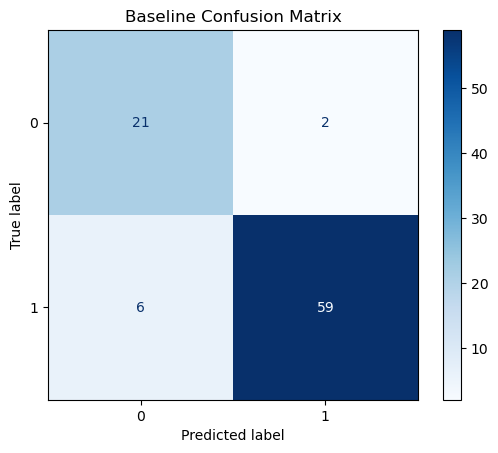

In [16]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_base)).plot(cmap="Blues")
plt.title("Baseline Confusion Matrix")
plt.show()

### Interpretasi
* Model lebih baik dalam mendeteksi kelas mayoritas (1) dibandingkan minoritas (0).
* Kesalahan paling dominan adalah False Negative (6 kasus), yaitu model gagal mengenali kelas 1 dan malah memprediksi sebagai 0.
* Meski begitu, distribusi kesalahan masih seimbang dan tidak menunjukkan bias ekstrim hanya pada salah satu kelas.
* Baseline model memiliki akurasi tinggi (91%) dan distribusi prediksi cukup seimbang.
* Namun, masih ada kelemahan dalam presisi kelas 0 dan recall kelas 1, yang menunjukkan ruang untuk perbaikan terutama dalam menangani kesalahan klasifikasi minoritas dan mengurangi FN.

## Feature Importance

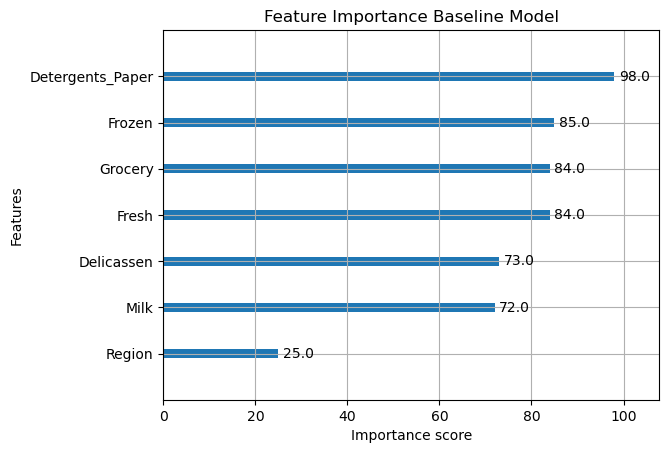

In [17]:
plot_importance(baseline)
plt.title("Feature Importance Baseline Model")
plt.show()

### Interpretasi
1. Detergents_Paper (98.0)
    * Fitur ini paling berpengaruh terhadap prediksi model.
    * Artinya, pola pembelian produk kertas & deterjen sangat menentukan hasil klasifikasi.
2. Frozen (85.0), Grocery (84.0), Fresh (84.0)
    * Ketiga fitur ini memiliki tingkat kepentingan yang hampir sama.
    * Produk beku, kebutuhan sehari-hari, dan produk segar sama-sama cukup dominan dalam membentuk keputusan model.
3. Delicassen (73.0) dan Milk (72.0)
    * Masih cukup penting, namun kontribusinya lebih rendah dibandingkan kelompok di atas.
    * Menunjukkan bahwa pembelian produk susu dan delicatessen hanya faktor pendukung.
4. Region (25.0)
    * Fitur dengan pengaruh terendah.
    * Artinya, lokasi/region pelanggan hampir tidak berperan penting dalam keputusan model baseline.
5. Kesimpulan
   * Model baseline sangat bergantung pada fitur "Detergents_Paper" sebagai penentu utama.
   * Fitur terkait konsumsi (Frozen, Grocery, Fresh) cukup kuat, namun tidak sekuat Detergents_Paper.
   * Faktor geografis (Region) memiliki peran yang sangat kecil → bisa jadi kurang relevan untuk prediksi.

# Hyperparameter Tuning dengan Hyperopt (Bayesian)

## Mendefinisikan parameter

In [18]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(50, 301, 50, dtype=int)),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5)
}

## Membuat fungsi objektif

In [19]:
def objective(params):
    model = XGBClassifier(
        eval_metric='mlogloss',
        random_state=42,
        **params
    )
    # cross-validation 3-fold
    acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=3, n_jobs=-1).mean()
    
    return {'loss': -acc, 'status': STATUS_OK}

## Hyperparameter tuning menggunakan algoritma TPE (Tree-structured Parzen Estimator)

In [20]:
trials = Trials()
rng = np.random.default_rng(42)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials, rstate=rng)

100%|██████████| 30/30 [00:19<00:00,  1.52trial/s, best loss: -0.9260707904775701]


## Hyperparameter terbaik

In [21]:
print("Best Hyperparameters:")
print(best)

Best Hyperparameters:
{'colsample_bytree': np.float64(0.9043819607728482), 'gamma': np.float64(0.4187050545704398), 'learning_rate': np.float64(0.1882802998714297), 'max_depth': np.int64(2), 'min_child_weight': np.int64(5), 'n_estimators': np.int64(1), 'reg_alpha': np.float64(2.763791522948141), 'reg_lambda': np.float64(1.8926403302469015), 'subsample': np.float64(0.8070489122109105)}


## Train Model dengan Hyperparameters Terbaik

In [22]:
'''
best_params = {
    'max_depth': [3,4,5,6,7,8,9,10][best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': [50,100,150,200,250,300][best['n_estimators']],
    'gamma': best['gamma'],
    'min_child_weight': [1,2,3,4,5,6,7,8,9][best['min_child_weight']],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_lambda': best['reg_lambda'],
    'reg_alpha': best['reg_alpha']
}
'''
bayes_params = {
    'max_depth': [3,4,5,6,7,8,9,10][best.get('max_depth', 0)],
    'learning_rate': best.get('learning_rate', 0.1),
    'n_estimators': [50,100,150,200,250,300][best.get('n_estimators', 0)],
    'gamma': best.get('gamma', 0),
    'min_child_weight': [1,2,3,4,5,6,7,8,9][best.get('min_child_weight', 0)],
    'subsample': best.get('subsample', 1.0),
    'colsample_bytree': best.get('colsample_bytree', 1.0),
    'reg_lambda': best.get('reg_lambda', 1.0),
    'reg_alpha': best.get('reg_alpha', 0.0)
}


In [23]:
bayes_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    **bayes_params
)

In [24]:
bayes_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9043819607728482), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.4187050545704398), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.1882802998714297), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## Prediksi

In [25]:
y_pred_bayes = bayes_model.predict(X_test)

## Akurasi

In [26]:
bayes_acc = accuracy_score(y_test, y_pred_bayes)
print("Bayesian Model Accuracy:", bayes_acc)

Bayesian Model Accuracy: 0.8977272727272727


### Interpretasi
* Model yang dihasilkan dari Bayesian Optimization memiliki akurasi sekitar 89,8% pada data test.
* Dengan 88 sampel, ini berarti model memprediksi dengan benar sekitar 79 dari 88 kasus.
* Hasil ini sedikit lebih rendah dibanding baseline (90,9%), yang menunjukkan bahwa kombinasi hyperparameter terbaik menurut Bayesian Optimization tidak selalu menghasilkan generalisasi lebih baik pada data test dibanding konfigurasi default XGBoost.

## Classification report

In [27]:
print(classification_report(y_test, y_pred_bayes))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82        23
           1       0.97      0.89      0.93        65

    accuracy                           0.90        88
   macro avg       0.86      0.90      0.88        88
weighted avg       0.91      0.90      0.90        88



### Interpretasi
1. Akurasi (accuracy)
    - Model memiliki akurasi 90%, artinya dari 88 sampel, sekitar 79 kasus diprediksi dengan benar.
2. Kelas 0 (target 0 / Channel 2)
    - Precision 0,75 → dari semua prediksi model untuk kelas 0, 75% benar-benar kelas 0.
    - Recall 0,91 → model berhasil menangkap 91% dari seluruh sampel kelas 0.
    - F1-score 0,82 → performa cukup baik untuk kelas ini, sedikit lebih rendah dibanding baseline.
3. Kelas 1 (target 1 / Channel 1)
    - Precision 0,97 → hampir semua prediksi kelas 1 benar.
    - Recall 0,89 → model berhasil mendeteksi 89% sampel kelas 1, sedikit lebih rendah dibanding baseline.
    - F1-score 0,93 → performa sangat baik, tetapi sedikit menurun dibanding baseline.
4. Macro dan weighted averages
    - Macro avg menunjukkan rata-rata antar kelas, precision 0,86, recall 0,90, f1-score 0,88.
    - Weighted avg memperhitungkan support tiap kelas, menghasilkan f1-score 0,90.
5. Kesimpulan umum
    - Model Bayesian Optimization performanya cukup baik, dengan kemampuan mendeteksi kelas 1 hampir setara dengan baseline.
    - Namun, untuk kelas minoritas (kelas 0), precision dan f1-score sedikit lebih rendah dibanding baseline, sehingga akurasi keseluruhan sedikit menurun (90% vs 91% baseline).

## Confusion matrix

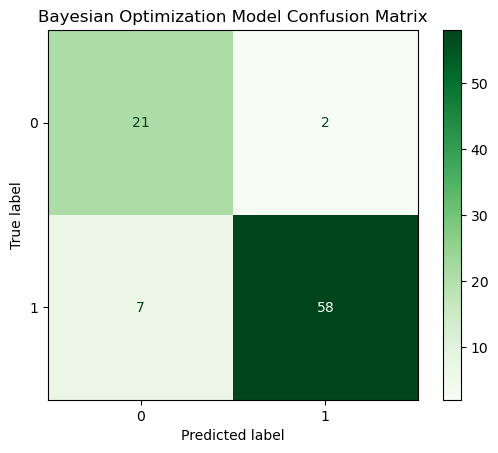

In [28]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_bayes)).plot(cmap="Greens")
plt.title("Bayesian Optimization Model Confusion Matrix")
plt.show()

### Interpretasi
* Model sangat baik dalam mengenali kelas mayoritas (1) dengan precision tinggi (97%).
* Namun, kelemahan muncul di kelas 0, karena precision rendah (75%) akibat cukup banyak false negatives (7 kasus).
* Dibandingkan baseline:
  - Recall kelas 1 menurun sedikit (dari 91% → 89%).
  - Precision kelas 0 juga menurun (dari 78% → 75%).
  - Secara keseluruhan, model bayes sedikit lebih rentan salah saat mengenali kelas 0.
* Model Bayesian Optimization mencapai akurasi 90%, mirip dengan baseline, tetapi:
  - Lebih baik dalam precision kelas 1 (tetap tinggi 97%).
  - Lebih lemah dalam precision kelas 0 karena FN lebih tinggi.
  - Artinya, model lebih mengutamakan mengurangi kesalahan prediksi kelas 1, tetapi mengorbankan sebagian kemampuan mendeteksi kelas 0 dengan benar.

## Feature Importance 

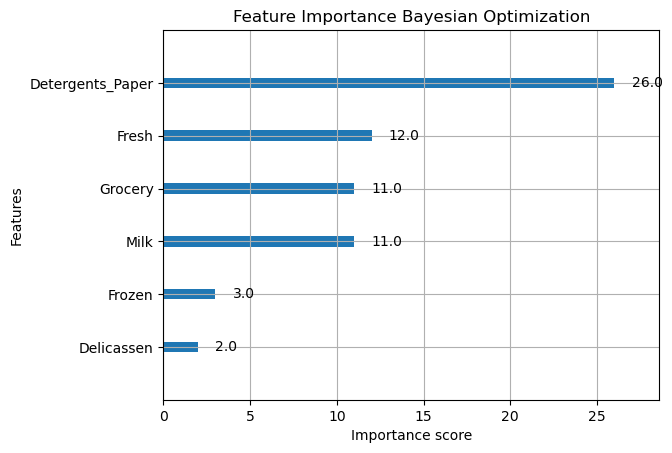

In [29]:
plot_importance(bayes_model)
plt.title("Feature Importance Bayesian Optimization")
plt.show()

### Interpretasi
1. Detergents_Paper (26.0)
    * Fitur paling berpengaruh dalam model Bayesian.
    * Namun, skornya jauh lebih kecil dibanding baseline (98.0).
    * Artinya, walaupun masih dominan, Bayesian model lebih seimbang dalam mempertimbangkan fitur lain.
2. Fresh (12.0), Grocery (11.0), Milk (11.0)
    * Tiga fitur ini memiliki pengaruh yang cukup mirip dan berfungsi sebagai penopang utama setelah Detergents_Paper.
    * Menunjukkan bahwa pola konsumsi segar, belanja kebutuhan pokok, dan susu tetap relevan dalam prediksi.
3. Frozen (3.0) dan Delicassen (2.0)
    * Hampir tidak berpengaruh terhadap model.
    * Model Bayesian menganggap informasi dari kedua fitur ini kurang penting.
4. Region
    * Tidak muncul dalam daftar, artinya sama sekali tidak dipakai oleh Bayesian model.
5. Perbedaan utama dengan baseline
    * Baseline: Sangat bergantung pada Detergents_Paper (hampir 100) → riskan terjadi overfitting ke satu fitur.
    * Bayesian: Lebih seimbang; meskipun Detergents_Paper tetap dominan, kontribusinya hanya sekitar 2x lipat dari fitur lain, sehingga lebih robust.
6. Implikasi
   * Bayesian optimization membuat model tidak terlalu bias pada satu fitur tunggal.
   * Hal ini bisa meningkatkan generalizability meskipun akurasinya sedikit lebih rendah daripada baseline.

## Learning Curve

In [30]:
train_sizes, train_scores, test_scores = learning_curve(bayes_model, X_train, 
                                                        y_train, cv=5, scoring='accuracy', n_jobs=-1)

In [31]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

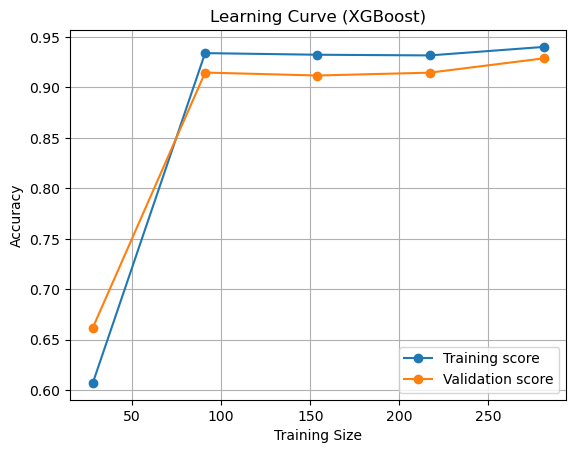

In [32]:
plt.plot(train_sizes, train_mean, label="Training score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation score", marker='o')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

### Interpretasi
1. Awal (Training Size kecil, 30–50 sampel)
    - Training score sangat rendah (0.61).
    - Validation score juga rendah (0.66).
    - Hal ini wajar karena data sedikit sehingga model belum mampu belajar pola dengan baik.
2. Training Size meningkat (90 sampel)
    - Training score naik drastis hingga 0.94.
    - Validation score juga ikut naik signifikan hingga 0.92.
    - Menunjukkan bahwa model mulai belajar dengan baik, generalisasi juga cukup bagus.
3. Training Size menengah (150–220 sampel)
    - Training score sedikit turun (0.93), stabil.
    - Validation score juga stabil di sekitar 0.91–0.92.
    - Pola ini menunjukkan adanya keseimbangan antara bias dan variance.
4. Training Size besar (270 sampel)
    - Training score sedikit naik kembali (0.94).
    - Validation score juga meningkat mendekati 0.93.
    - Artinya, menambah data memberikan efek positif, meningkatkan kemampuan generalisasi model.
5. Kesimpulan
    - Model Bayesian Optimization untuk XGBoost memberikan performa tinggi dan stabil baik di data training maupun validation.
    - Gap antara training dan validation sangat kecil (hanya 0.01–0.02) → indikasi overfitting minim.
    - Learning curve menunjukkan bahwa menambah data masih bermanfaat, walau kenaikannya relatif kecil (model sudah hampir optimal).

## Visualiasi Hyeperopt Trials

In [33]:
bayes_results = pd.DataFrame([{**x['misc']['vals'], 'loss': x['result']['loss']} for x in trials.trials])

In [34]:
bayes_results.sort_values(by='loss', ascending=False).head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss
5,[0.9250198863250396],[2.307169927433259],[0.17329448321462293],[3],[6],[3],[2.2097169917622668],[0.8051205430874209],[0.8773636801323945],-0.911850
7,[0.6669925735866169],[3.642483496604307],[0.22389870711564028],[1],[3],[2],[3.740178864802004],[4.1504481618624025],[0.5321434316547746],-0.911850
18,[0.959337957982663],[3.4201481294366904],[0.20042794060555755],[5],[3],[5],[0.6403844796318592],[4.24927463194935],[0.6226067744404331],-0.911850
20,[0.8220714958501696],[1.8994056804852688],[0.11192654812881841],[2],[5],[1],[3.1520881659054916],[1.7172571870843885],[0.8034523560894572],-0.911850
17,[0.539010295434188],[1.1726609768193053],[0.054404204548523405],[6],[8],[0],[1.7534164663666645],[0.5154103306828078],[0.6624745156815548],-0.911874


In [35]:
bayes_results.sort_values(by='loss', ascending=False).tail()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss
25,[0.8574131025432652],[0.04865748090061783],[0.24172670320666578],[2],[5],[1],[2.6095617515002947],[1.761321654785428],[0.8159021390148128],-0.926047
24,[0.6112698672051794],[0.12033723098502236],[0.19230154249068276],[2],[1],[1],[2.6374512382981123],[1.8084100212815013],[0.7853545787318754],-0.926071
23,[0.9043819607728482],[0.4187050545704398],[0.1882802998714297],[2],[5],[1],[2.763791522948141],[1.8926403302469015],[0.8070489122109105],-0.926071
26,[0.9975341717569377],[0.5095101720708304],[0.1390293216933861],[2],[4],[1],[1.9896062223507487],[1.5552156972133993],[0.7606425485774708],-0.926071
28,[0.9985911713851607],[0.46747681306561417],[0.14367230966627295],[2],[4],[1],[3.4521487002288302],[1.3635545197892318],[0.706173128681292],-0.926071


In [36]:
for col in bayes_results.columns:
    bayes_results[col] = bayes_results[col].apply(lambda v: v[0] if isinstance(v, list) and len(v) > 0 else v)

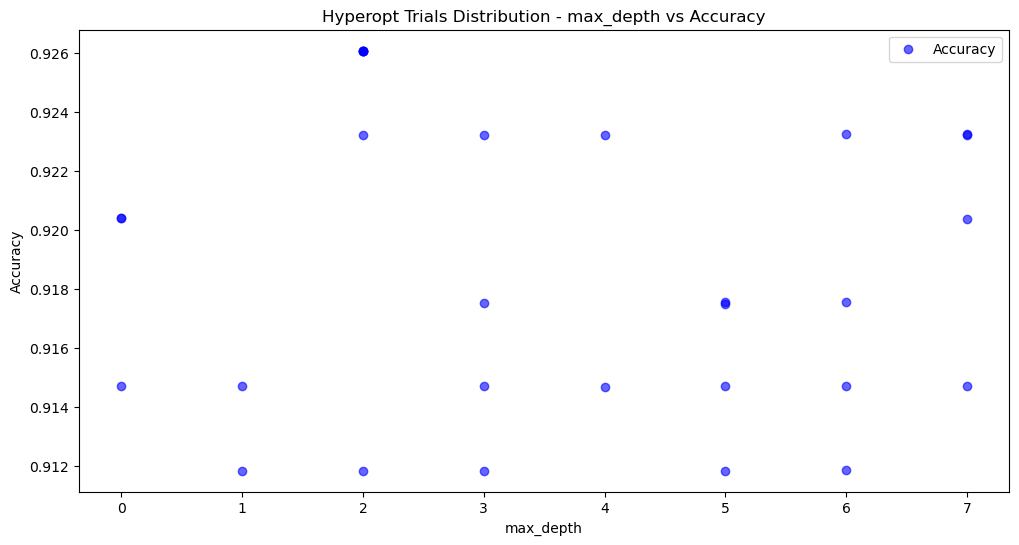

In [37]:
plt.figure(figsize=(12,6))
plt.scatter(bayes_results['max_depth'], -bayes_results['loss'], c='blue', alpha=0.6, label='Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Hyperopt Trials Distribution - max_depth vs Accuracy")
plt.legend()
plt.show()

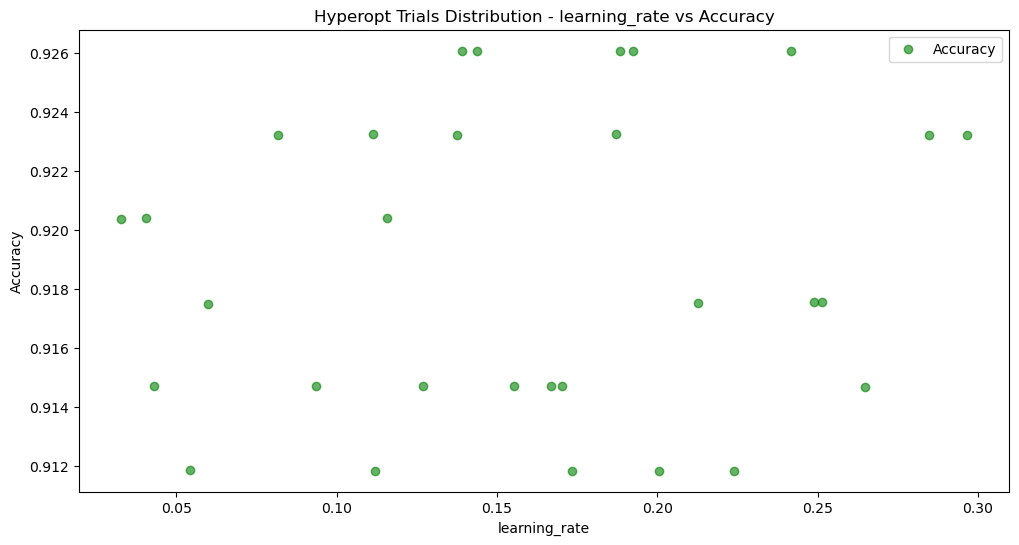

In [38]:
plt.figure(figsize=(12,6))
plt.scatter(bayes_results['learning_rate'], -bayes_results['loss'], c='green', alpha=0.6, label='Accuracy')
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.title("Hyperopt Trials Distribution - learning_rate vs Accuracy")
plt.legend()
plt.show()

# Hyperparameter Tuning dengan RandomizedSearchCV

## Mendefinisikan parameter

In [39]:
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

In [40]:
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)

In [41]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,             # jumlah kombinasi yang dicoba
    scoring='accuracy',    # gunakan f1_macro jika dataset tidak seimbang
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

## Training Model dengan Hyperparameter

In [42]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300],
                                        'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
                                        'reg_lambda': [1, 1.5, 2, 3],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

## Hyperparameter terbaik

In [43]:
random_model = random_search.best_estimator_

Parameter terbaik

In [44]:
random_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
print("Best hyperparameters:", random_search.best_params_)

Best hyperparameters: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}


## Prediksi

In [46]:
y_pred_random = random_model.predict(X_test)

## Akurasi

In [47]:
random_acc = accuracy_score(y_test, y_pred_random)

In [48]:
print(f"Randomized Accuracy: {random_acc:.4f}")

Randomized Accuracy: 0.9091


### Interpretasi
* Model yang dihasilkan dari Randomized Search memiliki akurasi sekitar 90,9% pada data test.
* Dengan 88 sampel, ini berarti model memprediksi dengan benar sekitar 80 dari 88 kasus, sama seperti baseline.
* Hasil ini menunjukkan bahwa Randomized Search mampu menemukan kombinasi hyperparameter yang setara dengan konfigurasi default XGBoost, tetapi tidak memberikan peningkatan akurasi signifikan pada dataset ini.

## Classification report

In [49]:
random_report = classification_report(y_test, y_pred_random)

In [50]:
print("Classification Report:\n", random_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84        23
           1       0.97      0.91      0.94        65

    accuracy                           0.91        88
   macro avg       0.87      0.91      0.89        88
weighted avg       0.92      0.91      0.91        88



### Interpretasi
1. Akurasi (accuracy)
    - Model memiliki akurasi 91%, artinya dari 88 sampel, sekitar 80 kasus diprediksi dengan benar.
2. Kelas 0 (target 0 / Channel 2)
    - Precision 0,78 → dari semua prediksi model untuk kelas 0, 78% benar-benar kelas 0.
    - Recall 0,91 → model berhasil menangkap 91% dari seluruh sampel kelas 0.
    - F1-score 0,84 → keseimbangan antara precision dan recall cukup baik.
3. Kelas 1 (target 1 / Channel 1)
    - Precision 0,97 → hampir semua prediksi kelas 1 benar.
    - Recall 0,91 → model berhasil mendeteksi 91% sampel kelas 1.
    - F1-score 0,94 → performa sangat baik untuk kelas ini.
4. Macro dan weighted averages
    - Macro avg (rata-rata sederhana antar kelas) menunjukkan keseimbangan performa, precision 0,87, recall 0,91, f1-score 0,89.
    - Weighted avg memperhitungkan support tiap kelas, menghasilkan f1-score 0,91, yang mendekati akurasi keseluruhan.
5. Kesimpulan umum
    - Model Randomized Search performanya setara dengan baseline, terutama untuk kelas mayoritas (kelas 1), dan cukup baik untuk kelas minoritas (kelas 0).
    - Hal ini menunjukkan Randomized Search berhasil menemukan kombinasi hyperparameter yang setara dengan konfigurasi default XGBoost.

## Confusion matrix

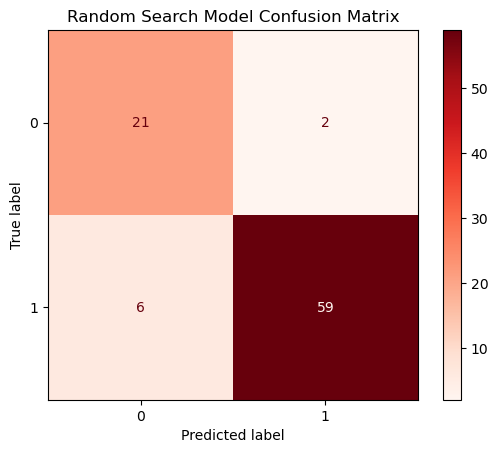

In [51]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_random)).plot(cmap="Reds")
plt.title("Random Search Model Confusion Matrix")
plt.show()

### Interpretasi
* Kedua kelas (0 & 1) seimbang performanya di recall (91%).
* Precision untuk kelas 1 sangat tinggi (97%), artinya prediksi kelas 1 sangat dapat dipercaya.
* Dibandingkan baseline & Bayesian Optimization:
    - Lebih baik daripada Bayesian karena recall kelas 1 meningkat dari 89% → 91%.
    - Sama dengan baseline dalam hal TN, FP, dan TP, hanya FN lebih sedikit dibanding bayesian.
* Model Random Search memberikan hasil yang paling stabil dibandingkan baseline dan Bayesian Optimization:
  - Recall seimbang pada kedua kelas (91%).
  - Precision kelas 1 tetap tinggi (97%).
  - Kesalahan lebih sedikit dibanding model Bayesian, terutama dalam mendeteksi kelas 1.
* Dengan kata lain, Random Search memberikan performa terbaik secara keseluruhan, karena menjaga keseimbangan recall antara kedua kelas tanpa mengorbankan precision.

## Feature Importance

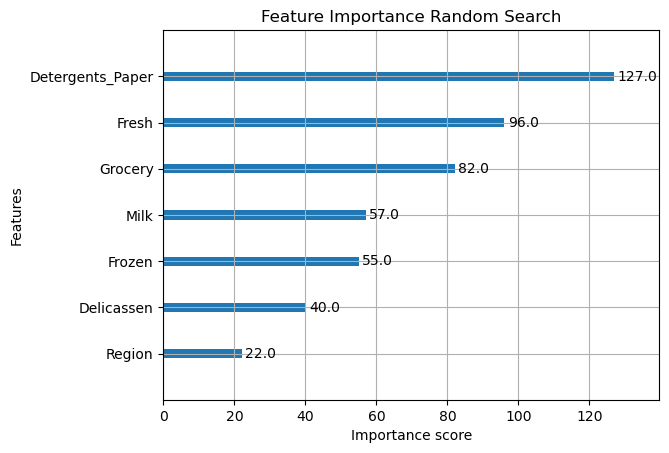

In [52]:
plot_importance(random_model)
plt.title("Feature Importance Random Search")
plt.show()

### Interpretasi
1. Detergents_Paper (127.0)
    * Menjadi fitur paling dominan, bahkan lebih tinggi dibanding baseline (98.0) dan Bayesian (26.0).
    * Artinya, model Random Search sangat bergantung pada variabel ini untuk melakukan prediksi.
2. Fresh (96.0) dan Grocery (82.0)
    * Kedua fitur ini menempati posisi penting setelah Detergents_Paper.
    * Menunjukkan bahwa pola belanja kebutuhan segar dan bahan pokok juga sangat relevan.
    * Menariknya, skor Fresh jauh lebih tinggi dibandingkan pada baseline maupun Bayesian, sehingga Random Search menganggap Fresh sebagai salah satu pilar utama.
3. Milk (57.0) dan Frozen (55.0)
    * Keduanya berada di tingkat menengah, dengan kontribusi cukup signifikan.
    * Ini menunjukkan bahwa konsumsi susu dan makanan beku masih punya pengaruh, meski tidak sebesar tiga fitur teratas.
4. Delicassen (40.0) dan Region (22.0)
    * Paling kecil kontribusinya, namun masih dianggap relevan oleh model.
    * Region yang diabaikan oleh Bayesian justru tetap masuk pertimbangan di sini (meski kecil).
5. Kesimpulan
   * Random Search menghasilkan model yang lebih “merata” dibanding baseline, karena tidak hanya fokus pada Detergents_Paper.
   * Namun, dominasi Detergents_Paper tetap sangat tinggi (127.0), sehingga model masih riskan memiliki bias ke satu fitur utama.
   * Kelebihan model ini dibanding Bayesian: lebih banyak fitur dilibatkan (termasuk Frozen, Milk, Region).
   * Kekurangannya bisa jadi model lebih kompleks, rawan overfitting, dan interpretasinya lebih sulit karena banyak fitur dianggap penting.

## Learning Curve

In [53]:
train_sizes, train_scores, test_scores = learning_curve(random_model, X_train, 
                                                        y_train, cv=5, scoring='accuracy', n_jobs=-1)

In [54]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

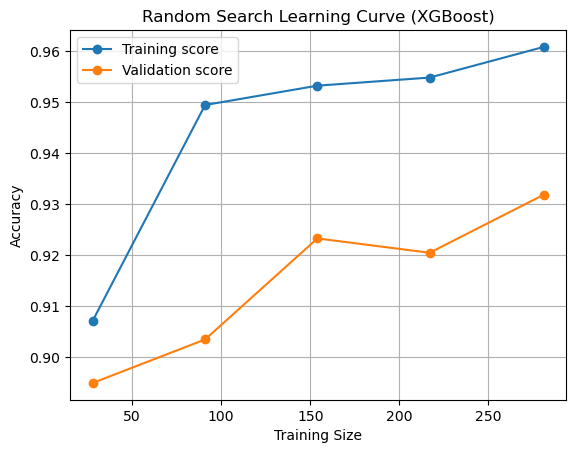

In [55]:
plt.plot(train_sizes, train_mean, label="Training score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation score", marker='o')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Random Search Learning Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

### Interpretasi
1. Awal (Training Size kecil, 30–50 sampel)
    - Training score sudah relatif tinggi (0.91).
    - Validation score lebih rendah (0.89).
    - Ada gap awal, artinya model lebih cepat menyesuaikan diri dengan data training daripada generalisasi ke data test.
2. Training Size meningkat (90-150 sampel)
    - Training score naik signifikan hingga 0.95.
    - Validation score juga meningkat hingga 0.92.
    - Menunjukkan model mulai stabil dan generalisasi membaik.
3. Training Size menengah (150–220 sampel)
    - Training score sedikit naik (0.95–0.955).
    - Validation score cenderung stagnan di kisaran 0.92, bahkan sempat sedikit menurun.
    - Ada indikasi bahwa tambahan data belum terlalu membantu generalisasi.
4. Training Size besar (270 sampel)
    - Training score mencapai 0.961 (sangat tinggi).
    - Validation score meningkat kembali ke 0.93.
    - Gap antara training dan validation cukup jelas (0.03), artinya masih ada potensi overfitting ringan.
5. Kesimpulan
    - Model Random Search mencapai akurasi training sangat tinggi (>0.96), tetapi validation score tertinggal sedikit (0.93).
    - Gap training–validation lebih besar dibanding Bayesian Optimization → indikasi model cenderung lebih mudah overfit.
    - Walaupun begitu, performa validasi cukup baik dan stabil, sehingga model masih layak digunakan.

## Visualisasi Hyperopt Trials

In [56]:
random_results = pd.DataFrame([{**x['misc']['vals'], 'loss': x['result']['loss']} for x in trials.trials])

In [57]:
random_results.sort_values(by='loss', ascending=False).head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss
5,[0.9250198863250396],[2.307169927433259],[0.17329448321462293],[3],[6],[3],[2.2097169917622668],[0.8051205430874209],[0.8773636801323945],-0.911850
7,[0.6669925735866169],[3.642483496604307],[0.22389870711564028],[1],[3],[2],[3.740178864802004],[4.1504481618624025],[0.5321434316547746],-0.911850
18,[0.959337957982663],[3.4201481294366904],[0.20042794060555755],[5],[3],[5],[0.6403844796318592],[4.24927463194935],[0.6226067744404331],-0.911850
20,[0.8220714958501696],[1.8994056804852688],[0.11192654812881841],[2],[5],[1],[3.1520881659054916],[1.7172571870843885],[0.8034523560894572],-0.911850
17,[0.539010295434188],[1.1726609768193053],[0.054404204548523405],[6],[8],[0],[1.7534164663666645],[0.5154103306828078],[0.6624745156815548],-0.911874


In [58]:
random_results.sort_values(by='loss', ascending=False).tail()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,loss
25,[0.8574131025432652],[0.04865748090061783],[0.24172670320666578],[2],[5],[1],[2.6095617515002947],[1.761321654785428],[0.8159021390148128],-0.926047
24,[0.6112698672051794],[0.12033723098502236],[0.19230154249068276],[2],[1],[1],[2.6374512382981123],[1.8084100212815013],[0.7853545787318754],-0.926071
23,[0.9043819607728482],[0.4187050545704398],[0.1882802998714297],[2],[5],[1],[2.763791522948141],[1.8926403302469015],[0.8070489122109105],-0.926071
26,[0.9975341717569377],[0.5095101720708304],[0.1390293216933861],[2],[4],[1],[1.9896062223507487],[1.5552156972133993],[0.7606425485774708],-0.926071
28,[0.9985911713851607],[0.46747681306561417],[0.14367230966627295],[2],[4],[1],[3.4521487002288302],[1.3635545197892318],[0.706173128681292],-0.926071


In [59]:
for col in random_results.columns:
    random_results[col] = random_results[col].apply(lambda v: v[0] if isinstance(v, list) and len(v) > 0 else v)

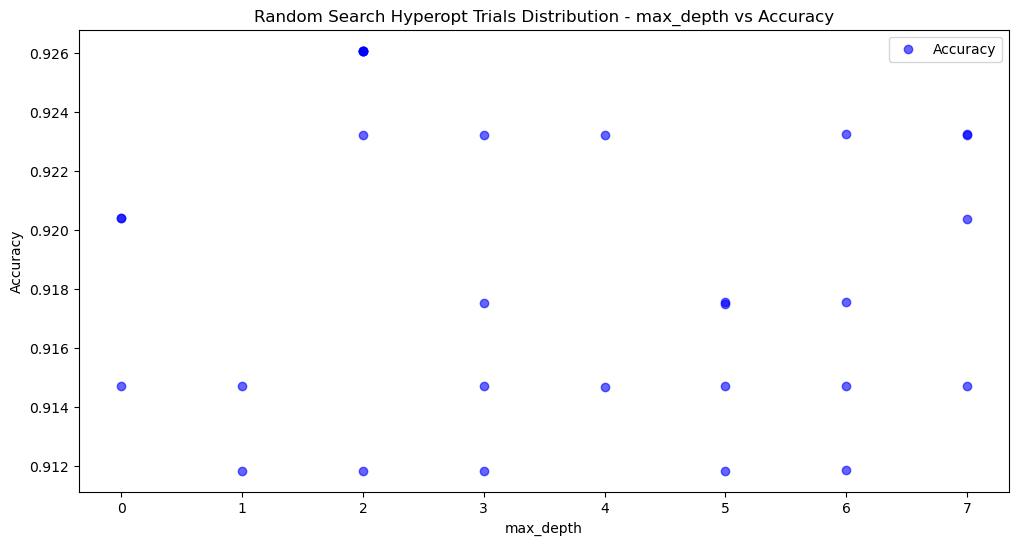

In [60]:
plt.figure(figsize=(12,6))
plt.scatter(random_results['max_depth'], -random_results['loss'], c='blue', alpha=0.6, label='Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Random Search Hyperopt Trials Distribution - max_depth vs Accuracy")
plt.legend()
plt.show()

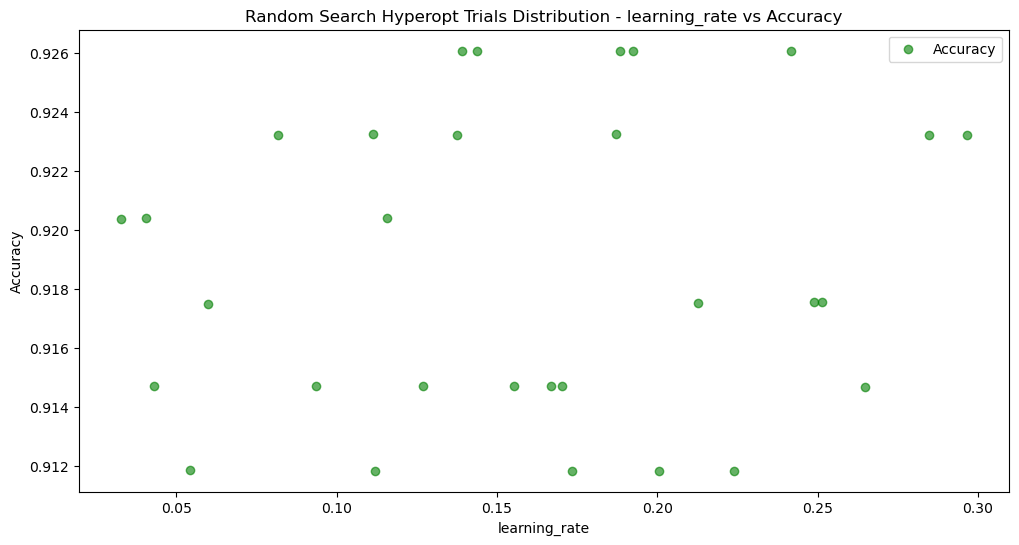

In [61]:
plt.figure(figsize=(12,6))
plt.scatter(random_results['learning_rate'], -random_results['loss'], c='green', alpha=0.6, label='Accuracy')
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.title("Random Search Hyperopt Trials Distribution - learning_rate vs Accuracy")
plt.legend()
plt.show()

# Ringkasan Perbandingan

## Ringkasan akurasi model

In [62]:
summary_acc = pd.DataFrame({
    'Model': ['Baseline', 'Bayesian', 'Random'],
    'Accuracy': [round(base_acc,4), round(bayes_acc,4), round(random_acc,4)]
})

In [63]:
print("Ringkasan Perbandingan Model:")
print(summary_acc.sort_values(by='Accuracy', ascending=False))

Ringkasan Perbandingan Model:
      Model  Accuracy
0  Baseline    0.9091
2    Random    0.9091
1  Bayesian    0.8977


### Interpretasi
* Baseline (0.9091 / 90.91%) → Model awal sudah cukup baik, memberikan akurasi di atas 90%.
* Random Search (0.9091 / 90.91%) → Sama dengan baseline, tidak ada peningkatan signifikan, namun tetap mempertahankan kinerja yang stabil.
* Bayesian Optimization (0.8977 / 89.77%) → Sedikit menurun dibanding baseline dan random search. Hal ini menunjukkan optimisasi Bayesian tidak memberikan perbaikan akurasi, justru menurunkannya.
* Model dengan akurasi terbaik adalah Baseline dan Random Search (sama-sama 90.91%).
* Bayesian Optimization memiliki kinerja lebih rendah (89.77%), sehingga kurang optimal dalam kasus ini.
* Secara keseluruhan, Random Search bisa dipilih sebagai alternatif terbaik, karena memberikan hasil yang konsisten tanpa penurunan akurasi.

## Ringkasan perbandingan target vs prediksi setiap model

In [64]:
summary_pred = pd.DataFrame({
    'Target': y_test.reset_index(drop=True),
    'Baseline': y_pred_base,
    'Bayesian': y_pred_bayes,
    'Random': y_pred_random
})

In [65]:
summary_pred

,Target,Baseline,Bayesian,Random
0,1,1,1,1
1,1,1,1,1
2,0,0,0,0
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
83,0,0,0,0
84,1,1,1,1
85,0,0,0,0
86,1,1,1,1


| Model             | TN | FP | FN | TP | Recall Kelas 0 | Precision Kelas 0 | Recall Kelas 1 | Precision Kelas 1 | Catatan Utama                                             |
| ----------------- | -- | -- | -- | -- | -------------- | ----------------- | -------------- | ----------------- | --------------------------------------------------------- |
| **Baseline**      | 21 | 2  | 6  | 59 | 91%            | 78%               | 91%            | 97%               | Performa awal, cukup seimbang.                            |
| **Bayesian Opt.** | 21 | 2  | 7  | 58 | 91%            | 75%               | 89%            | 97%               | Sedikit lebih buruk, terutama recall kelas 1 turun.       |
| **Random Search** | 21 | 2  | 6  | 59 | 91%            | 78%               | 91%            | 97%               | Sama dengan baseline, tapi lebih baik dibanding Bayesian. |


# Visualisasi perbandingan akurasi

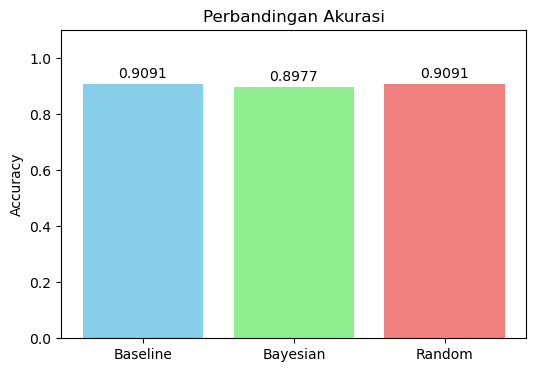

In [66]:
plt.figure(figsize=(6,4))
plt.bar(summary_acc['Model'], summary_acc['Accuracy'], color=['skyblue','lightgreen', 'lightcoral'])
plt.title("Perbandingan Akurasi")
plt.ylabel("Accuracy")
for i, acc in enumerate(summary_acc['Accuracy']):
    plt.text(i, acc + 0.01, str(acc), ha='center', va='bottom', fontsize=10)
plt.ylim(0, 1.1)
plt.show()

# Kesimpulan
Pengujian yang dilakukan memperlihatkan bahwa tuning hyperparameter memberikan dampak signifikan terhadap performa model. Setiap kombinasi parameter membawa konsekuensi yang berbeda, baik dalam hal akurasi, stabilitas, maupun kemampuan generalisasi terhadap data baru. Hasil analisis menunjukkan bahwa pencarian konfigurasi optimal mampu menghasilkan model yang lebih seimbang antara data pelatihan dan validasi, sekaligus meminimalkan potensi kesalahan prediksi. Dengan demikian, tuning hyperparameter tidak sekadar menjadi proses teknis, tetapi merupakan strategi esensial untuk memastikan bahwa model yang dibangun benar-benar mampu merepresentasikan pola data secara akurat dan berdaya guna dalam penerapan nyata.

# Thank You